C:\Users\hskma\AppData\Local\Temp\ipykernel_12156\1694851761.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, pd.DataFrame([row])], ignore_index=True)


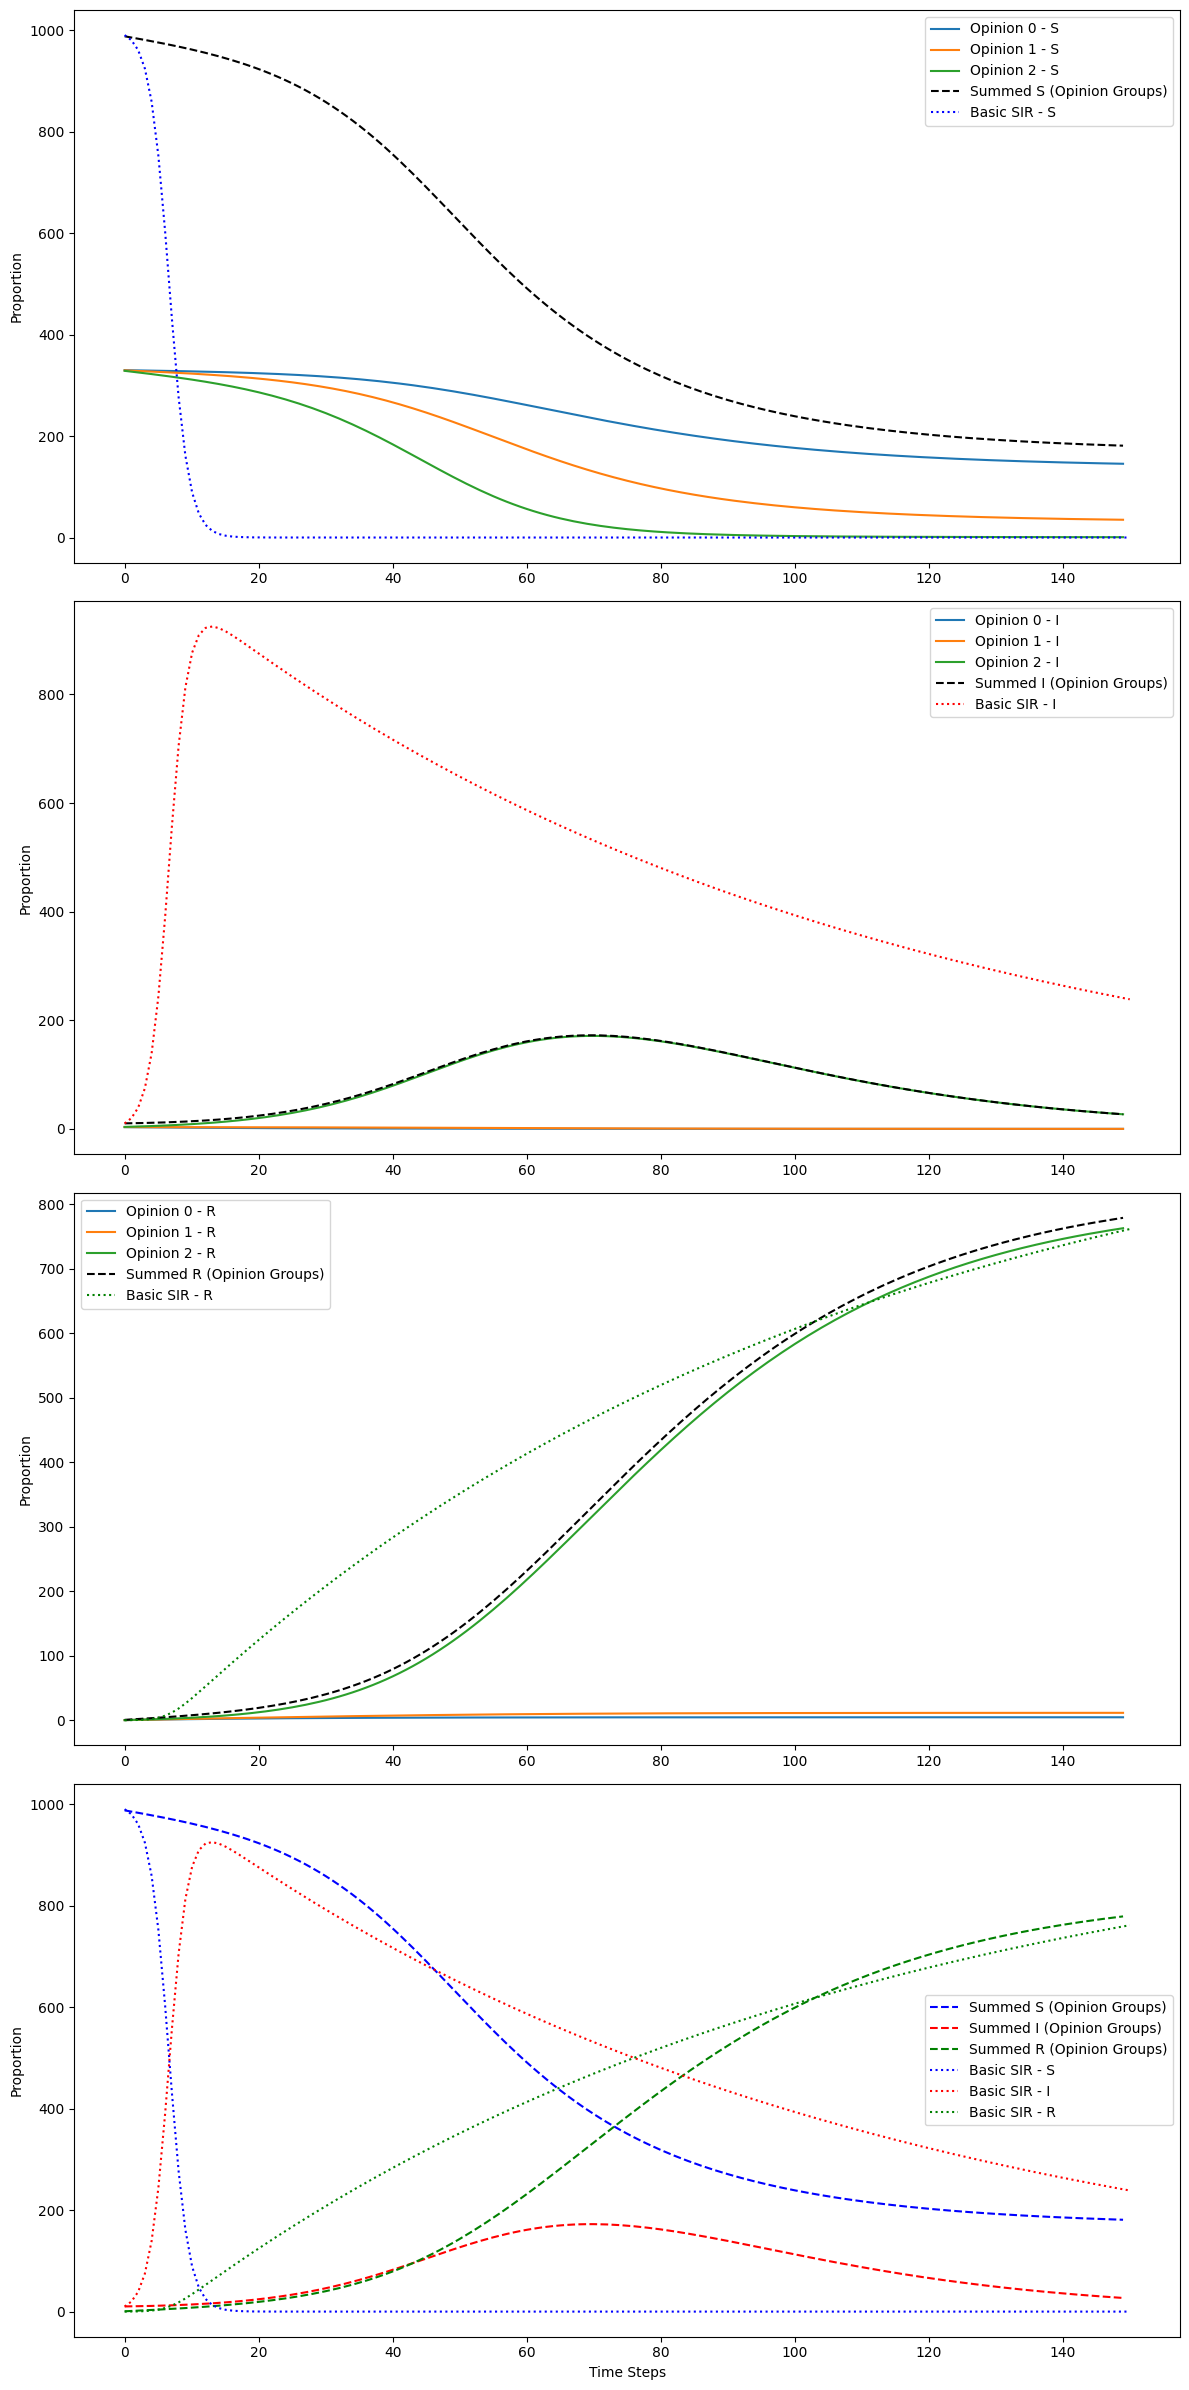

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Basic SIR model parameters and initial values
N = 1000
int_I = 0.01 * N
int_R = 0
int_S = N - int_I - int_R  # S_0 is starting susceptible
beta = 0.7
gamma = 0.01
MaxTime = 150
RunTime = np.linspace(0, MaxTime, MaxTime)

# Define the system of differential equations for the basic SIR model
def Find_Deriv(y, RunTime, N, beta, gamma):
    int_S, int_I, int_R = y
    dsdt = -beta * int_S * int_I / N
    didt = (beta * int_S * int_I / N) - (gamma * int_I)
    drdt = gamma * int_I
    return dsdt, didt, drdt

# Initial conditions for the basic SIR model
y_0 = int_S, int_I, int_R

# Integrate the system of differential equations for the basic SIR model
coord = odeint(Find_Deriv, y_0, RunTime, args=(N, beta, gamma))
basic_S, basic_I, basic_R = coord.T

# Number of opinion groups (indexed from 0 to n), which can be changed accordingly if needed
n = 2  # The total number of opinion groups

# Below is the function to calculate the probability distribution over the opinions
def pi(q, n):
    # This is basically the softmax function that we are using to compute the probability distribution
    return np.exp(q) / np.sum(np.exp(np.arange(n + 1)))

# Initialization of initial values for all the S, I, R in each opinion group
initial_values = {f'P_S_{i}': float(int_S / (n + 1)) for i in range(n + 1)}
initial_values.update({f'P_I_{i}': float(int_I / (n + 1)) for i in range(n + 1)})
initial_values.update({f'P_R_{i}': float(int_R / (n + 1)) for i in range(n + 1)})

# Differential equations for the SIR model with opinions
def dS(t, y, row, O, beta, N, n):
    return -pi(O, n) * beta * row[f'P_S_{O}'] * sum(row[f'P_I_{j}'] for j in range(n + 1)) / N

def dI(t, y, row, O, beta, gamma, N, n):
    return pi(O, n) * beta * row[f'P_I_{O}'] * sum(row[f'P_S_{j}'] for j in range(n + 1)) / (3*N) - (3 * n) * gamma * row[f'P_I_{O}']

def dR(t, y, row, O, gamma, n):
    return (3 * n) * gamma * row[f'P_I_{O}']

# Runge-Kutta method for solving differential equations
def runge(f, t, y0, *args):
    n = len(t)
    U = np.zeros(n)
    U[0] = y0
    h = t[1] - t[0]  # Step size is based on the t array

    for j in range(n - 1):
        k1 = f(t[j], U[j], *args)
        k2 = f(t[j] + h / 2, U[j] + h / 2 * k1, *args)
        U[j + 1] = U[j] + h * k2

    return U[-1]

# Functions to update the proportions of S, I, and R in each opinion group
def update_proportions_S(row, beta, N, n, t):
    for i in range(n + 1):
        row[f'P_S_{i}'] = runge(dS, t, row[f'P_S_{i}'], row, i, beta, N, n)
    return row

def update_proportions_I(row, beta, gamma, N, n, t):
    for i in range(n + 1):
        row[f'P_I_{i}'] = runge(dI, t, row[f'P_I_{i}'], row, i, beta, gamma, N, n)
    return row

def update_proportions_R(row, gamma, n, t):
    for i in range(n + 1):
        row[f'P_R_{i}'] = runge(dR, t, row[f'P_R_{i}'], row, i, gamma, n)
    return row

# Main simulation function
def run_simulation(initial_values, beta, gamma, steps, N, n):
    t = np.linspace(0, 1, 2)  # Time step for the Runge-Kutta method

    # Define the column names for the DataFrame
    columns = [f'P_S_{i}' for i in range(n + 1)] + [f'P_I_{i}' for i in range(n + 1)] + [f'P_R_{i}' for i in range(n + 1)]

    # Create an empty DataFrame with the specified columns
    data = pd.DataFrame(columns=columns)

    # Initialization of the row with the initial values
    row = initial_values.copy()

    # Run the simulation for the specified number of steps
    for _ in range(steps):
        row = update_proportions_S(row, beta, N, n, t)
        row = update_proportions_I(row, beta, gamma, N, n, t)
        row = update_proportions_R(row, gamma, n, t)
        data = pd.concat([data, pd.DataFrame([row])], ignore_index=True)

    return data

# Function to plot the simulation results
def plot_simulation_2d(data, basic_S, basic_I, basic_R, RunTime, n):
    num_plots = n + 1  # Total number of opinion groups
    fig, axes = plt.subplots(4, 1, figsize=(12, 24))

    # Plot S, I, R for each opinion group
    for i in range(num_plots):
        axes[0].plot(data.index, data[f'P_S_{i}'], label=f'Opinion {i} - S')
        axes[1].plot(data.index, data[f'P_I_{i}'], label=f'Opinion {i} - I')
        axes[2].plot(data.index, data[f'P_R_{i}'], label=f'Opinion {i} - R')

    # Plot summed proportions for opinion groups SIR
    summed_S = data[[f'P_S_{i}' for i in range(num_plots)]].sum(axis=1)
    summed_I = data[[f'P_I_{i}' for i in range(num_plots)]].sum(axis=1)
    summed_R = data[[f'P_R_{i}' for i in range(num_plots)]].sum(axis=1)

    axes[0].plot(data.index, summed_S, label='Summed S (Opinion Groups)', color='black', linestyle='--')
    axes[1].plot(data.index, summed_I, label='Summed I (Opinion Groups)', color='black', linestyle='--')
    axes[2].plot(data.index, summed_R, label='Summed R (Opinion Groups)', color='black', linestyle='--')

    # Plot basic SIR model results
    axes[0].plot(RunTime, basic_S, label='Basic SIR - S', color='blue', linestyle=':')
    axes[1].plot(RunTime, basic_I, label='Basic SIR - I', color='red', linestyle=':')
    axes[2].plot(RunTime, basic_R, label='Basic SIR - R', color='green', linestyle=':')

    # Set labels and legend for individual plots
    for i in range(3):
        axes[i].set_ylabel('Proportion')
        axes[i].legend()

    # Plot summed SIR proportions separately
    axes[3].plot(data.index, summed_S, label='Summed S (Opinion Groups)', color='blue', linestyle='--')
    axes[3].plot(data.index, summed_I, label='Summed I (Opinion Groups)', color='red', linestyle='--')
    axes[3].plot(data.index, summed_R, label='Summed R (Opinion Groups)', color='green', linestyle='--')
    axes[3].plot(RunTime, basic_S, label='Basic SIR - S', color='blue', linestyle=':')
    axes[3].plot(RunTime, basic_I, label='Basic SIR - I', color='red', linestyle=':')
    axes[3].plot(RunTime, basic_R, label='Basic SIR - R', color='green', linestyle=':')
    axes[3].set_xlabel('Time Steps')
    axes[3].set_ylabel('Proportion')
    axes[3].legend()

    plt.tight_layout()
    plt.show()

# Run the opinion groups SIR model simulation
data = run_simulation(initial_values, beta, gamma, MaxTime, N, n)

# Plot the results for both the basic SIR model and the opinion groups SIR model
plot_simulation_2d(data, basic_S, basic_I, basic_R, RunTime, n)


C:\Users\hskma\AppData\Local\Temp\ipykernel_12984\2786208067.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, pd.DataFrame([row])], ignore_index=True)


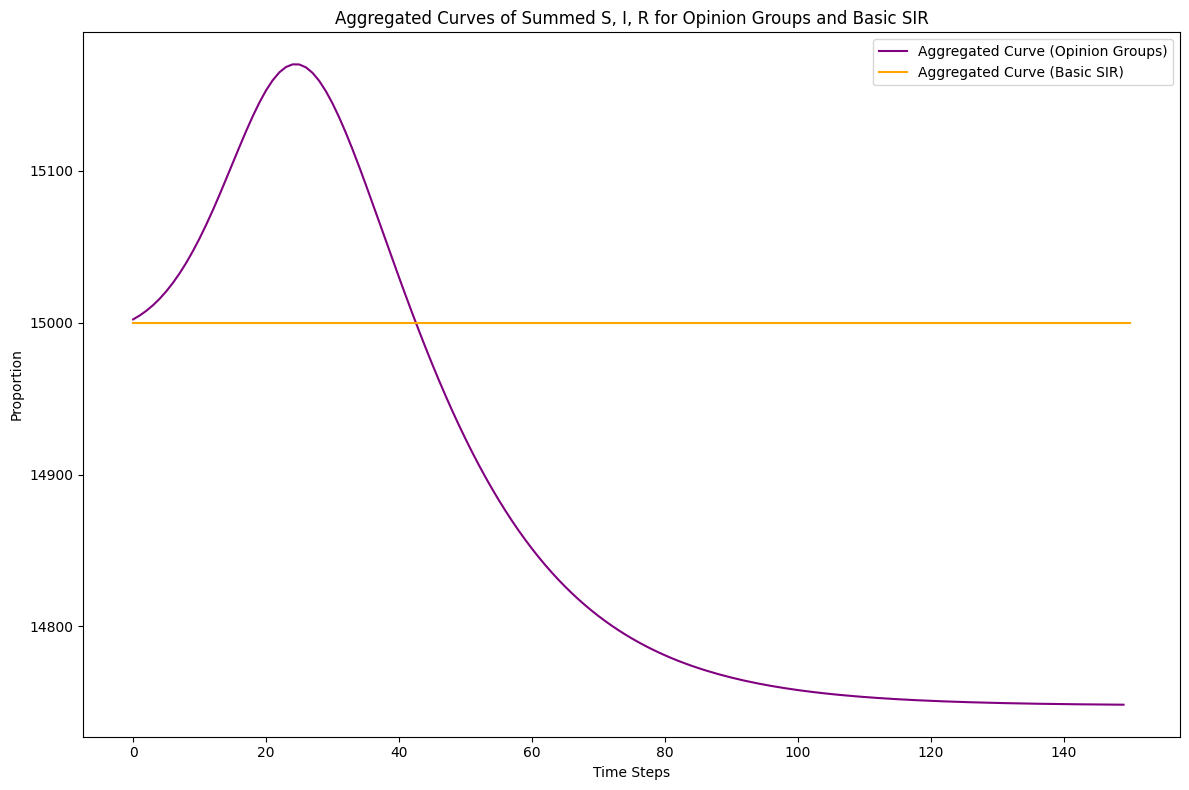

In [4]:
def plot_aggregated_simulation(data, basic_S, basic_I, basic_R, RunTime, n):
    # Summed proportions for opinion groups SIR
    summed_S = data[[f'P_S_{i}' for i in range(n + 1)]].sum(axis=1)
    summed_I = data[[f'P_I_{i}' for i in range(n + 1)]].sum(axis=1)
    summed_R = data[[f'P_R_{i}' for i in range(n + 1)]].sum(axis=1)
    
    # Aggregate the S, I, R curves for opinion groups
    aggregated_curve_opinion = summed_S + summed_I + summed_R

    # Aggregate the S, I, R curves for basic SIR model
    aggregated_curve_basic = basic_S + basic_I + basic_R

    # Plot aggregated results
    plt.figure(figsize=(12, 8))
    plt.plot(data.index, aggregated_curve_opinion, label='Aggregated Curve (Opinion Groups)', color='purple', linestyle='-')
    plt.plot(RunTime, aggregated_curve_basic, label='Aggregated Curve (Basic SIR)', color='orange', linestyle='-')

    # Set labels and legend
    plt.xlabel('Time Steps')
    plt.ylabel('Proportion')
    plt.legend()
    plt.title('Aggregated Curves of Summed S, I, R for Opinion Groups and Basic SIR')
    plt.tight_layout()
    plt.show()

# Run the opinion groups SIR model simulation
data = run_simulation(initial_values, beta, gamma, MaxTime, N, n)

# Plot the aggregated results for both the basic SIR model and the opinion groups SIR model
plot_aggregated_simulation(data, basic_S, basic_I, basic_R, RunTime, n)


C:\Users\hskma\AppData\Local\Temp\ipykernel_9768\4149667949.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, pd.DataFrame([row])], ignore_index=True)


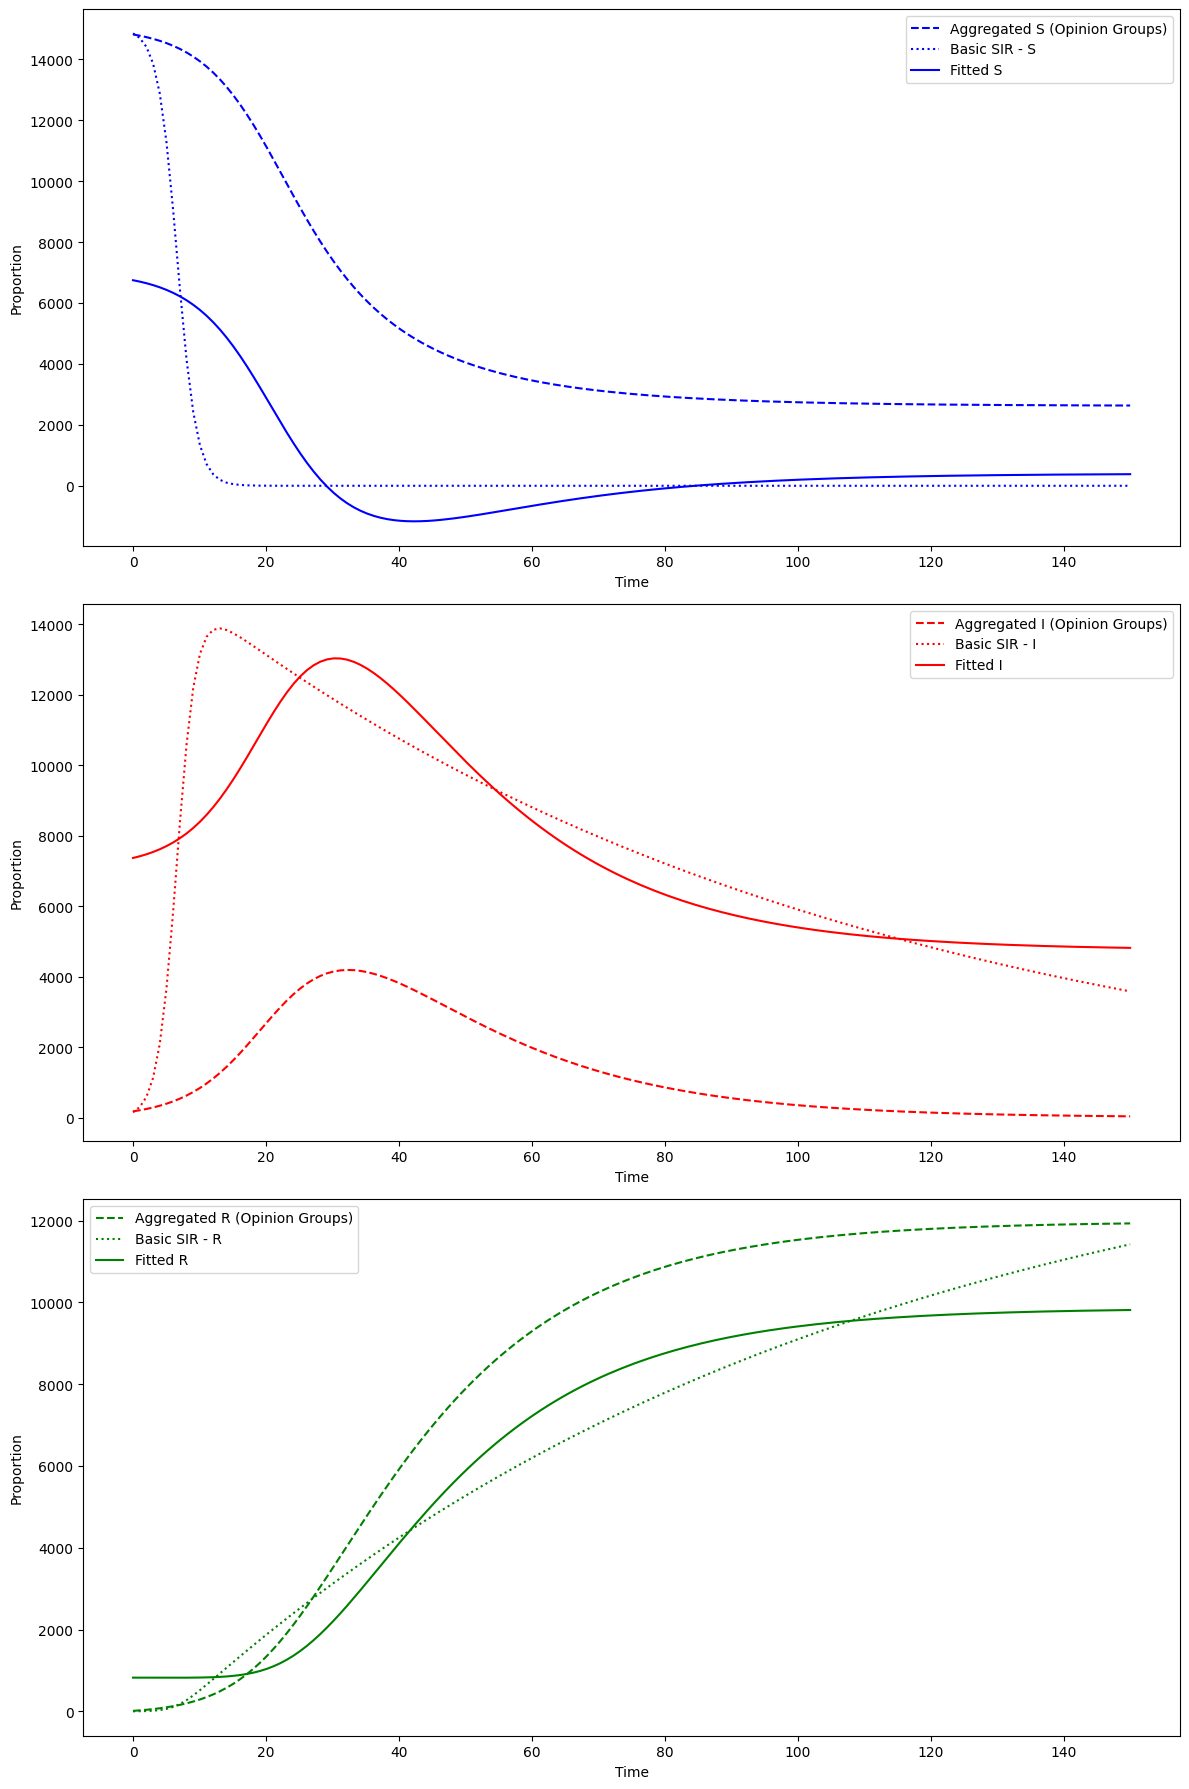

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import curve_fit

# Basic SIR model parameters and initial values
N = 15000
int_I = 0.01 * N
int_R = 0
int_S = N - int_I - int_R
beta = 0.7
gamma = 0.01
MaxTime = 150
RunTime = np.linspace(0, MaxTime, MaxTime)

# Define the system of differential equations for the basic SIR model
def Find_Deriv(y, RunTime, N, beta, gamma):
    int_S, int_I, int_R = y
    dsdt = -beta * int_S * int_I / N
    didt = (beta * int_S * int_I / N) - (gamma * int_I)
    drdt = gamma * int_I
    return dsdt, didt, drdt

# Initial conditions for the basic SIR model
y_0 = int_S, int_I, int_R

# Integrate the system of differential equations for the basic SIR model
coord = odeint(Find_Deriv, y_0, RunTime, args=(N, beta, gamma))
basic_S, basic_I, basic_R = coord.T

# Number of opinion groups (indexed from 0 to n), which can be changed accordingly if needed
n = 2  # The total number of opinion groups

# Below is the function to calculate the probability distribution over the opinions
def pi(q, n):
    return np.exp(q) / np.sum(np.exp(np.arange(n + 1)))

# Initialization of initial values for all the S, I, R in each opinion group
initial_values = {f'P_S_{i}': float(int_S / (n + 1)) for i in range(n + 1)}
initial_values.update({f'P_I_{i}': float(int_I / (n + 1)) for i in range(n + 1)})
initial_values.update({f'P_R_{i}': float(int_R / (n + 1)) for i in range(n + 1)})

# Differential equations for the SIR model with opinions
def dS(t, y, row, O, beta, N, n):
    return -pi(O, n) * beta * row[f'P_S_{O}'] * sum(row[f'P_I_{j}'] for j in range(n + 1)) / N

def dI(t, y, row, O, beta, gamma, N, n):
    return pi(O, n) * beta * row[f'P_S_{O}'] * sum(row[f'P_I_{j}'] for j in range(n + 1)) / N - (3 * n) * gamma * row[f'P_I_{O}']

def dR(t, y, row, O, gamma, n):
    return (3 * n) * gamma * row[f'P_I_{O}']

# Runge-Kutta method for solving differential equations
def runge(f, t, y0, *args):
    n = len(t)
    U = np.zeros(n)
    U[0] = y0
    h = t[1] - t[0]

    for j in range(n - 1):
        k1 = f(t[j], U[j], *args)
        k2 = f(t[j] + h / 2, U[j] + h / 2 * k1, *args)
        U[j + 1] = U[j] + h * k2

    return U[-1]

# Functions to update the proportions of S, I, and R in each opinion group
def update_proportions_S(row, beta, N, n, t):
    for i in range(n + 1):
        row[f'P_S_{i}'] = runge(dS, t, row[f'P_S_{i}'], row, i, beta, N, n)
    return row

def update_proportions_I(row, beta, gamma, N, n, t):
    for i in range(n + 1):
        row[f'P_I_{i}'] = runge(dI, t, row[f'P_I_{i}'], row, i, beta, gamma, N, n)
    return row

def update_proportions_R(row, gamma, n, t):
    for i in range(n + 1):
        row[f'P_R_{i}'] = runge(dR, t, row[f'P_R_{i}'], row, i, gamma, n)
    return row

# Main simulation function
def run_simulation(initial_values, beta, gamma, steps, N, n):
    t = np.linspace(0, 1, 2)

    columns = [f'P_S_{i}' for i in range(n + 1)] + [f'P_I_{i}' for i in range(n + 1)] + [f'P_R_{i}' for i in range(n + 1)]
    data = pd.DataFrame(columns=columns)

    row = initial_values.copy()

    for _ in range(steps):
        row = update_proportions_S(row, beta, N, n, t)
        row = update_proportions_I(row, beta, gamma, N, n, t)
        row = update_proportions_R(row, gamma, n, t)
        data = pd.concat([data, pd.DataFrame([row])], ignore_index=True)

    return data

# Aggregate the opinion-based model values
def aggregate_opinion_model(data, n):
    aggregated_S = data[[f'P_S_{i}' for i in range(n + 1)]].sum(axis=1)
    aggregated_I = data[[f'P_I_{i}' for i in range(n + 1)]].sum(axis=1)
    aggregated_R = data[[f'P_R_{i}' for i in range(n + 1)]].sum(axis=1)
    return aggregated_S, aggregated_I, aggregated_R

# Fit a curve using MSE
def mse_curve_fit(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Run the opinion groups SIR model simulation
data = run_simulation(initial_values, beta, gamma, MaxTime, N, n)

# Aggregate the opinion-based model values
aggregated_S, aggregated_I, aggregated_R = aggregate_opinion_model(data, n)

# Fit a curve between aggregated opinion-based model and basic SIR model using MSE
def fit_curve(x, a, b, c):
    return a * x[0] + b * x[1] + c * x[2]

# Combine all aggregated data for fitting
x_data = np.array([aggregated_S, aggregated_I, aggregated_R])
y_data_S = basic_S
y_data_I = basic_I
y_data_R = basic_R

popt_S, _ = curve_fit(fit_curve, x_data, y_data_S)
popt_I, _ = curve_fit(fit_curve, x_data, y_data_I)
popt_R, _ = curve_fit(fit_curve, x_data, y_data_R)

fitted_S = fit_curve(x_data, *popt_S)
fitted_I = fit_curve(x_data, *popt_I)
fitted_R = fit_curve(x_data, *popt_R)

# Plot the results
def plot_simulation_aggregated(aggregated_S, aggregated_I, aggregated_R, basic_S, basic_I, basic_R, fitted_S, fitted_I, fitted_R, RunTime):
    fig, ax = plt.subplots(3, 1, figsize=(12, 18))

    ax[0].plot(RunTime, aggregated_S, label='Aggregated S (Opinion Groups)', color='blue', linestyle='--')
    ax[0].plot(RunTime, basic_S, label='Basic SIR - S', color='blue', linestyle=':')
    ax[0].plot(RunTime, fitted_S, label='Fitted S', color='blue')
    
    ax[1].plot(RunTime, aggregated_I, label='Aggregated I (Opinion Groups)', color='red', linestyle='--')
    ax[1].plot(RunTime, basic_I, label='Basic SIR - I', color='red', linestyle=':')
    ax[1].plot(RunTime, fitted_I, label='Fitted I', color='red')

    ax[2].plot(RunTime, aggregated_R, label='Aggregated R (Opinion Groups)', color='green', linestyle='--')
    ax[2].plot(RunTime, basic_R, label='Basic SIR - R', color='green', linestyle=':')
    ax[2].plot(RunTime, fitted_R, label='Fitted R', color='green')

    for i in range(3):
        ax[i].set_xlabel('Time')
        ax[i].set_ylabel('Proportion')
        ax[i].legend()

    plt.tight_layout()
    plt.show()

plot_simulation_aggregated(aggregated_S, aggregated_I, aggregated_R, basic_S, basic_I, basic_R, fitted_S, fitted_I, fitted_R, RunTime)


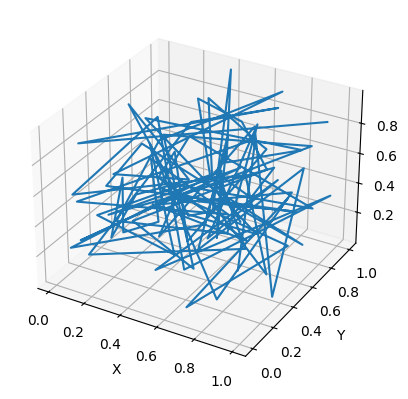

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot3d(triples):
    # Extract x, y, z coordinates from triples
    x = [triple[0] for triple in triples]
    y = [triple[1] for triple in triples]
    z = [triple[2] for triple in triples]
    
    # Create a new figure for plotting
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the points as a line
    ax.plot(x, y, z)
    
    # Set labels for the axes
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # Show the plot
    plt.show()

# Example usage:
import numpy as np
triples = [np.random.rand(3) for _ in range(100)]
plot3d(triples)
